In [1]:
# This notebook is aimed to deal with the transiant state
# it trains and searches the best model and saves it.

In [ ]:
from DataPrepocessing import *
from NeuralNets import *
from TrainMethod import *

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler

### Some pre-defined parameters

In [3]:
sequence_length = 10
batch_size = 16

In [4]:
# first,read the data and do some data analysis

### Do the data prepocessing

In [5]:
P1T1_to_P06T1 = pd.read_csv('./transiant_data/P1T1_to_P0.6T1.csv', index_col= 0)

In [6]:
P1T1_to_P06T1.columns

Index(['keff', 'keff_relative_uncertainty', 'keff_absolute_uncertainty',
       'Cs137_0 [at/b.cm]', 'Cs137_1 [at/b.cm]', 'Cs137_2 [at/b.cm]',
       'Cs137_3 [at/b.cm]', 'Cs137_4 [at/b.cm]', 'Cs137_5 [at/b.cm]',
       'Cs137_6 [at/b.cm]',
       ...
       'Cs137_824 [at/b.cm]', 'Cs137_825 [at/b.cm]', 'Cs137_826 [at/b.cm]',
       'Cs137_827 [at/b.cm]', 'Cs137_828 [at/b.cm]', 'Cs137_829 [at/b.cm]',
       'Cs137_830 [at/b.cm]', 'Cs137_831 [at/b.cm]', 'Cs137_832 [at/b.cm]',
       'Cs137_833 [at/b.cm]'],
      dtype='object', length=837)

In [7]:
def process(df):
    # read in a pandas frame, remove the keff_relative_uncertainty and keff_absolute_uncertainty
    # return the keff and the data columns

    df = df.drop('keff_relative_uncertainty',axis = 1)
    df = df.drop('keff_absolute_uncertainty', axis = 1)

    keff = df.pop('keff')

    # print(type(df))

    return keff, df

In [8]:
keff, data = process(P1T1_to_P06T1)

data.columns


Index(['Cs137_0 [at/b.cm]', 'Cs137_1 [at/b.cm]', 'Cs137_2 [at/b.cm]',
       'Cs137_3 [at/b.cm]', 'Cs137_4 [at/b.cm]', 'Cs137_5 [at/b.cm]',
       'Cs137_6 [at/b.cm]', 'Cs137_7 [at/b.cm]', 'Cs137_8 [at/b.cm]',
       'Cs137_9 [at/b.cm]',
       ...
       'Cs137_824 [at/b.cm]', 'Cs137_825 [at/b.cm]', 'Cs137_826 [at/b.cm]',
       'Cs137_827 [at/b.cm]', 'Cs137_828 [at/b.cm]', 'Cs137_829 [at/b.cm]',
       'Cs137_830 [at/b.cm]', 'Cs137_831 [at/b.cm]', 'Cs137_832 [at/b.cm]',
       'Cs137_833 [at/b.cm]'],
      dtype='object', length=834)

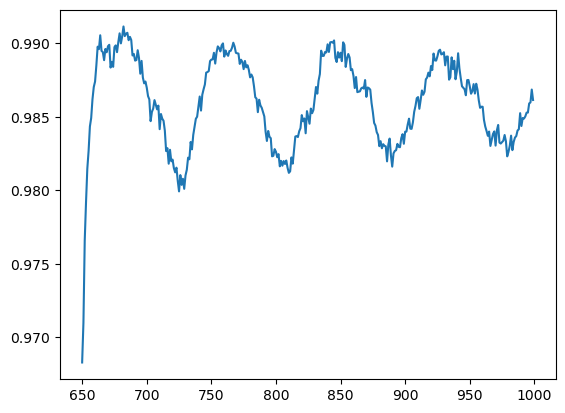

In [9]:
plt.plot(keff)

In [10]:
def generate_histogram(data: np.ndarray, binInt = 1.0e-06, binMax = 1.5e-04):
    '''
    Take in a data with columns are features  Transform the features with histogram method
    '''

    # Extract data
    Xvals = data

    nRows, nCols = Xvals.shape

    # define bins
    hEdges = np.arange(0, binMax+binInt, binInt)
    nBins = len(hEdges)-1


    # fill histogram matrix
    nCountsX = np.zeros((nRows, nBins), dtype=np.uint16)
    for n in range(nRows):
        nCountsX[n,:], _ = np.histogram(Xvals[n,:], hEdges)
    return nCountsX

In [11]:
hist_data = generate_histogram(data.to_numpy())

In [12]:
data.iloc[0,:]

Cs137_0 [at/b.cm]     NaN
Cs137_1 [at/b.cm]     NaN
Cs137_2 [at/b.cm]     NaN
Cs137_3 [at/b.cm]     NaN
Cs137_4 [at/b.cm]     NaN
                       ..
Cs137_829 [at/b.cm]   NaN
Cs137_830 [at/b.cm]   NaN
Cs137_831 [at/b.cm]   NaN
Cs137_832 [at/b.cm]   NaN
Cs137_833 [at/b.cm]   NaN
Name: 650, Length: 834, dtype: float64

In [13]:
hist_data[0] # this is super wired, all cs in first row is nan

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint16)

In [14]:
# align the data such that each row is a keff and the cesian concetration from last step

# delete the fist element in keff

keff = keff.to_numpy()
keff = keff[1:]
print(keff.shape)

# delete the last row in hist_data

hist_data = hist_data[:-1]
print(hist_data.shape)

(349,)
(349, 150)


In [ ]:
'''
a reminder, shoule we remove the first column since all cs is 0? Remove it！
'''

'\na reminder, shoule we remove the first column since all cs is 0?\n'

In [16]:
# Then, we concentrate keff and data together

all_data = np.append(hist_data, keff.reshape(-1,1), axis=1)
all_data.shape

(349, 151)

In [17]:
# cut the data length so it can fit time sequence length, which is 10



all_data = all_data[: len(all_data)//sequence_length * sequence_length]

In [18]:
# add power and threshold


# keep the first 50 as 1 since all power and thereshold are 1
def add_one_column_after_50 (arr,new_col_value):
    # Create a new column of single value to add to the front of the array
    new_col = np.concatenate((np.ones(50), np.full((arr.shape[0]-50,), new_col_value)))

    # Use insert to insert the new column to the front of the array
    new_arr = np.insert(arr, 0, new_col, axis=1)

    return new_arr

def add_Power_and_Threshold(arr, p = 1, t = 1):
    arr = add_one_column_after_50(arr, p)
    arr = add_one_column_after_50(arr, t)

    return arr

all_data = add_Power_and_Threshold(all_data, 0.6, 1)





In [19]:
# combine all the above step

def get_data(filename, p =1, t = 1):
    df = pd.read_csv(filename, index_col= 0)

    keff, data = process(df)
    hist_data = generate_histogram(data.to_numpy())

    # delete the fist element in keff

    keff = keff.to_numpy()
    keff = keff[1:]
    # print(keff.shape)

    # delete the last row in hist_data

    hist_data = hist_data[:-1]
    # print(hist_data.shape)

    all_data = np.append(hist_data, keff.reshape(-1,1), axis=1)


    all_data = all_data[: len(all_data)//sequence_length * sequence_length]

    all_data = add_Power_and_Threshold(all_data, p ,t)

    return all_data
    


In [20]:
# lets get the data

P1T1_to_P06T1 = get_data('./transiant_data/P1T1_to_P0.6T1.csv',0.6,1)

P1T1_to_P08T1 = get_data('./transiant_data/P1T1_to_P0.8T1.csv',0.8,1)

P1T1_to_P1T11 = get_data('./transiant_data/P1T1_to_P1T1.1.csv',1,1.1)

P1T1_to_P1T09 = get_data('./transiant_data/P1T1_to_P1T0.9.csv',1,0.9)




In [21]:
P1T1_to_P06T1.shape

(340, 153)

In [22]:
# concentrate all data together and do the standarlize
add_order = [P1T1_to_P06T1,P1T1_to_P08T1,P1T1_to_P1T11,P1T1_to_P1T09]
all_data = np.concatenate(add_order, axis=0)
all_data.shape

(1360, 153)

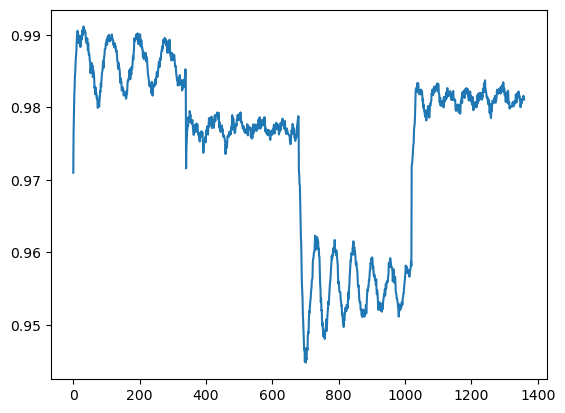

In [23]:
plt.plot(all_data[:,-1])

### Add stable data

In [24]:
# then, we need to add the stable data to the training set
# stable data is where the power and threshold is a constant
stable_data = np.loadtxt('stable_data.csv', delimiter= ',', dtype= np.float64)
print(stable_data.shape)

(1600, 153)


In [25]:
all_data = np.concatenate([all_data, stable_data], axis = 0)

### Do the standarlize

In [26]:
data = all_data

ss = StandardScaler()

data = ss.fit_transform(data)


clean_data = data.copy()

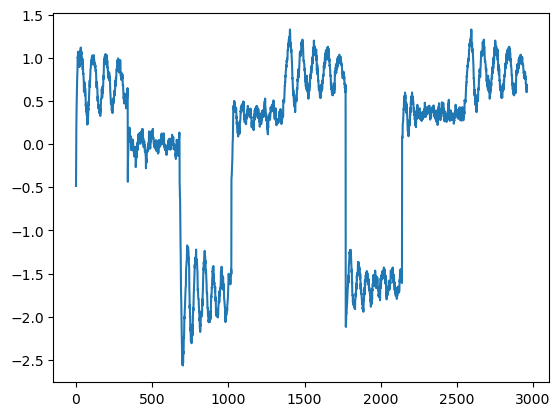

In [27]:
plt.plot(data[:,-1])

In [28]:
# define the training and testing set
training_data = ReactorData(data,sequence_length,0,1)


testing_data = ReactorData(data,sequence_length,0.65,1)

training_and_testing_data = ReactorData(data,sequence_length,0,1)

### Training 

In [29]:
# define neural nets

input_dim = training_data[0][0].shape[1]



# print(output_dim)

# some adjustable hyper-parameters
nets_hyper_parameters = {
'input_dim' : input_dim,
'output_dim' : 1,
'hidden_dim' : 256,
'lstm_nums_layer' : 2,
'dropout' : 0.2 
}


model = SimpleLSTM(**nets_hyper_parameters)

In [30]:
model.parameters

<bound method Module.parameters of SimpleLSTM(
  (LSTM): LSTM(152, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden_to_output): Linear(in_features=256, out_features=1, bias=True)
)>

In [31]:
optimizer_parameters = {
    'params':model.parameters(),
    'lr' : 0.005,
    'weight_decay' : 0.005
    #'amsgrad' : True
}
# 

train_parameters = {
    'model' : model,
    'training_data' : training_data,
    'epoch_num': 5,
    'batch_size':batch_size,
    'optimizer' : optim.Adam(**optimizer_parameters),
    'loss_fn' : nn.MSELoss(),
    'print_out_frequency': 20,
    'shuffle': True

}


model, _ = train(** train_parameters)

The loss is 0.1564141609743285 in epoch 0
Training is finished, the final loss is 0.13855877827964652


In [ ]:
# input_dim, hidden_dim, output_dim, lstm_nums_layer, dropout
best_model = SimpleLSTM(input_dim, 128,1, 2, 0.05)

best_model.load_state_dict(torch.load('brilliantlstm.pth'))
best_model.to(torch.double)
best_model.eval()

### Visualize the training result

In [32]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def eval(data, batch_size, sequence_length):
    # Assuming you have a DataSet object called 'training_data' and a trained model called 'model'
    training_set = data
    # Step 1: Create a DataLoader from your DataSet object
    batch_size = batch_size  # Adjust this value based on your model's input requirements
    train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)

    # Step 2 & 3: Iterate through the DataLoader and collect predictions and true labels
    predictions = []
    true_labels = []

    sequence_length = sequence_length  # Assuming a sequence length of 10

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in train_loader:
            # Pass the input data to the trained model and collect the predictions
            preds = model(inputs)
            preds = preds.reshape(-1, sequence_length)  # Reshape the predictions to (batch_size, sequence_length, output_dim)
            predictions.extend(preds.squeeze().view(-1).tolist())  # Flatten the predictions
            true_labels.extend(labels.squeeze().view(-1).tolist())  # Flatten the true labels

    # Step 4: Plot the predictions and true labels for comparison
    loss = nn.MSELoss()
    tensor1 = torch.tensor(predictions)
    tensor2 = torch.tensor(true_labels)
    test_loss = loss(tensor1, tensor2)
    print(test_loss)
    plt.figure()
    plt.xlabel('Timestamp')
    plt.ylabel('Keff')
    plt.plot(true_labels, label="Real")
    plt.plot(predictions, label="Predict", alpha = 0.7)
    plt.legend()
    plt.show()

    return np.array(true_labels), np.array(predictions)


In [33]:
training_label, training_pred =  eval(training_data, batch_size, sequence_length)

tensor(0.0712)


: 

: 

tensor(0.0303)


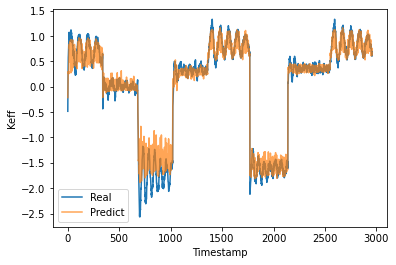

In [ ]:
all_label, all_pred =  eval(training_and_testing_data, batch_size, sequence_length)

tensor(0.0132)


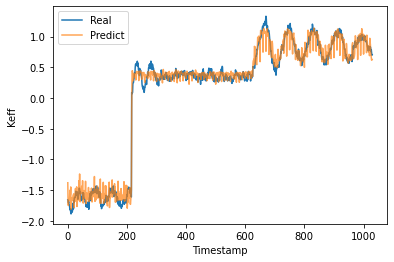

In [ ]:
all_test_label, all_test_pred =  eval(testing_data, batch_size, sequence_length)

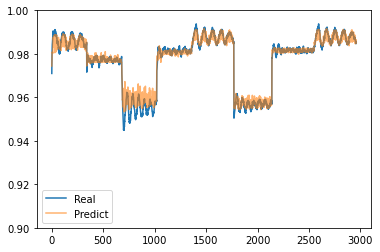

In [ ]:
# change to the original unit
true_labels = all_label
predictions = all_pred
X = training_and_testing_data.unshaped_data

result_y = np.append(X, true_labels.reshape(-1,1), axis=1)
result_predict = np.append(X, predictions.reshape(-1,1), axis=1)

y = ss.inverse_transform(result_y)
predict = ss.inverse_transform(result_predict)

plt.figure()
plt.ylim((0.9,1))
plt.plot(y[:,-1], label = "Real")     
plt.plot(predict[:,-1], label = "Predict", alpha = 0.6)
plt.legend()


In [ ]:
first_run_data = np.loadtxt('first_run.csv', delimiter= ',', dtype= np.float64)
second_run_data = np.loadtxt('second_run.csv', delimiter= ',', dtype= np.float64)

first_run_data = np.concatenate([first_run_data, second_run_data], axis = 0)

In [ ]:
print(first_run_data.shape)

(1280, 153)


In [ ]:
first_ss = StandardScaler()

first_run_data = first_ss.fit_transform(first_run_data)
first_run_dataset = ReactorData(first_run_data, sequence_length, 0 ,1)


tensor(0.1614)


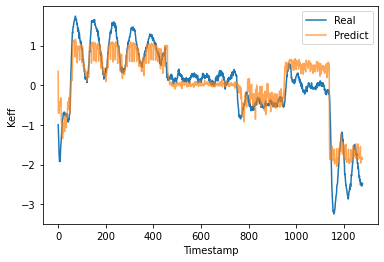

In [ ]:
all_labels, predictions =  eval(first_run_dataset, batch_size, sequence_length)

In [ ]:
X = first_run_dataset.unshaped_data
plt.plot(X[0,:])

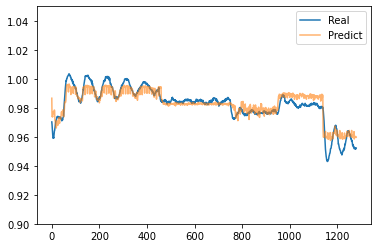

In [ ]:
# change to the original unit
true_labels = all_labels
predictions = predictions
X = first_run_dataset.unshaped_data

result_y = np.append(X, true_labels.reshape(-1,1), axis=1)
result_predict = np.append(X, predictions.reshape(-1,1), axis=1)

y = first_ss.inverse_transform(result_y)
predict = first_ss.inverse_transform(result_predict)

plt.figure()
plt.ylim((0.9,1.05))
plt.plot(y[:,-1], label = "Real")     
plt.plot(predict[:,-1], label = "Predict", alpha = 0.6)
plt.legend()




### For the challenging run

In [ ]:
hard_run_data = np.loadtxt('challenging_run.csv', delimiter= ',', dtype= np.float64)



In [ ]:
hard_ss = StandardScaler()

hard_run_data = first_ss.fit_transform(hard_run_data)
hard_run_dataset = ReactorData(hard_run_data, sequence_length, 0 ,1)


In [ ]:
all_labels, predictions =  eval(hard_run_dataset, batch_size, sequence_length)

In [ ]:
# change to the original unit
true_labels = all_labels
predictions = predictions
X = hard_run_dataset.unshaped_data

result_y = np.append(X, true_labels.reshape(-1,1), axis=1)
result_predict = np.append(X, predictions.reshape(-1,1), axis=1)

y = first_ss.inverse_transform(result_y)
predict = first_ss.inverse_transform(result_predict)

plt.figure()
plt.ylim((0.9,1.05))
plt.plot(y[:,-1], label = "Real")     
plt.plot(predict[:,-1], label = "Predict", alpha = 0.6)
plt.legend()


In [ ]:
### Fine tuning hyperparameters

In [ ]:
# will do this later, specifically wrapping training and evaluation into functions and fine tuning like that

In [ ]:
'''
some points

should add some stable data?
should increse model size?
should do some more data prepocessing?
should use pre-trained model?
'''

'\nsome points\n\nshould add some stable data?\nshould increse model size?\nshould do some more data prepocessing?\nshould use pre-trained model?\n'